In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import re
from transformers import pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, jaccard_score


# Load data
data_x = pd.read_csv("x.csv")
data_r = pd.read_csv("reddit.csv")

# Display the first few rows of the dataset
print("First 5 rows of the x dataset:")
print(data_x.head())
print("\nFirst 5 rows of the reddit dataset:")
print(data_r.head())

# Display information about the dataset
print("\nx data information:")
print(data_x.info())
print("\nreddit data information:")
print(data_r.info())

D:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


First 5 rows of the x dataset:
   tweet_id     user_handle            timestamp  \
0         1        @user123  2024-11-03 08:45:00   
1         2    @politicsFan  2024-11-03 09:15:23   
2         3  @greenAdvocate  2024-11-03 10:05:45   
3         4     @indieVoice  2024-11-03 11:20:10   
4         5   @libertyLover  2024-11-03 12:35:55   

                                          tweet_text       candidate  \
0  Excited to see Kamala Harris leading the Democ...   Kamala Harris   
1  Donald Trump's policies are the best for our e...    Donald Trump   
2  Jill Stein's environmental plans are exactly w...      Jill Stein   
3  Robert Kennedy offers a fresh perspective outs...  Robert Kennedy   
4  Chase Oliver's libertarian stance promotes tru...    Chase Oliver   

               party  retweets  likes sentiment  
0   Democratic Party       120    450  positive  
1   Republican Party        85    300  positive  
2        Green Party        60    200  positive  
3        Independent   

# Analyzing Interactions Across X and Reddit Data

This section visualizes and compares interactions (e.g., retweets, likes, upvotes, and replies) on two platforms: X (formerly Twitter) and Reddit. The goal is to identify patterns and differences in public engagement with political candidates across these platforms.


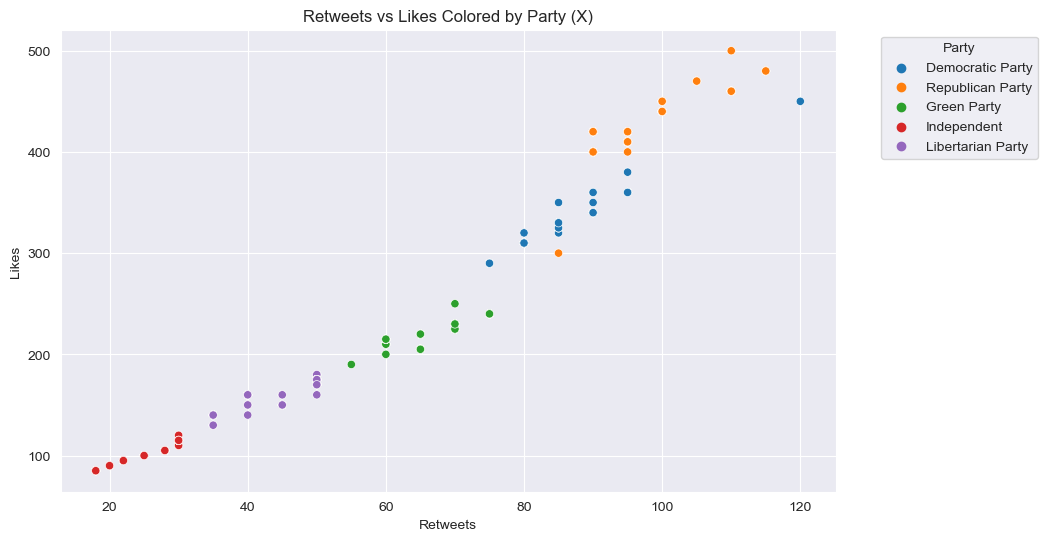

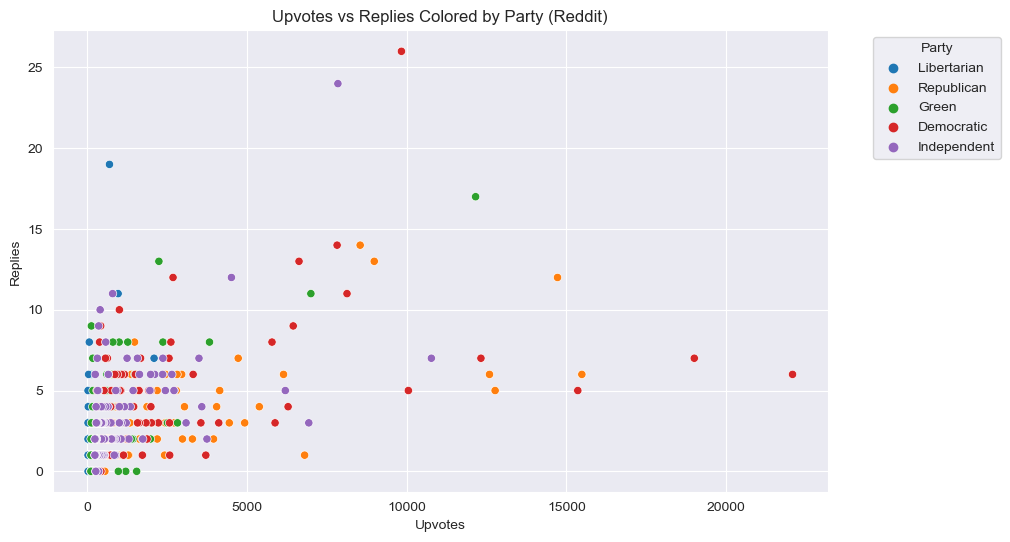


Combined average interaction stats per candidate:
                Avg Retweets (X)  Avg Likes (X)  Avg Upvotes (Reddit)  \
candidate                                                               
Chase Oliver               43.90         158.20                106.42   
Donald Trump               98.55         430.50               2184.84   
Jill Stein                 67.25         222.75                716.72   
Kamala Harris              86.60         332.35               2228.86   
Robert Kennedy             24.88         100.80               1195.11   

                Avg Replies (Reddit)  
candidate                             
Chase Oliver                    2.28  
Donald Trump                    3.17  
Jill Stein                      2.54  
Kamala Harris                   4.01  
Robert Kennedy                  3.64  


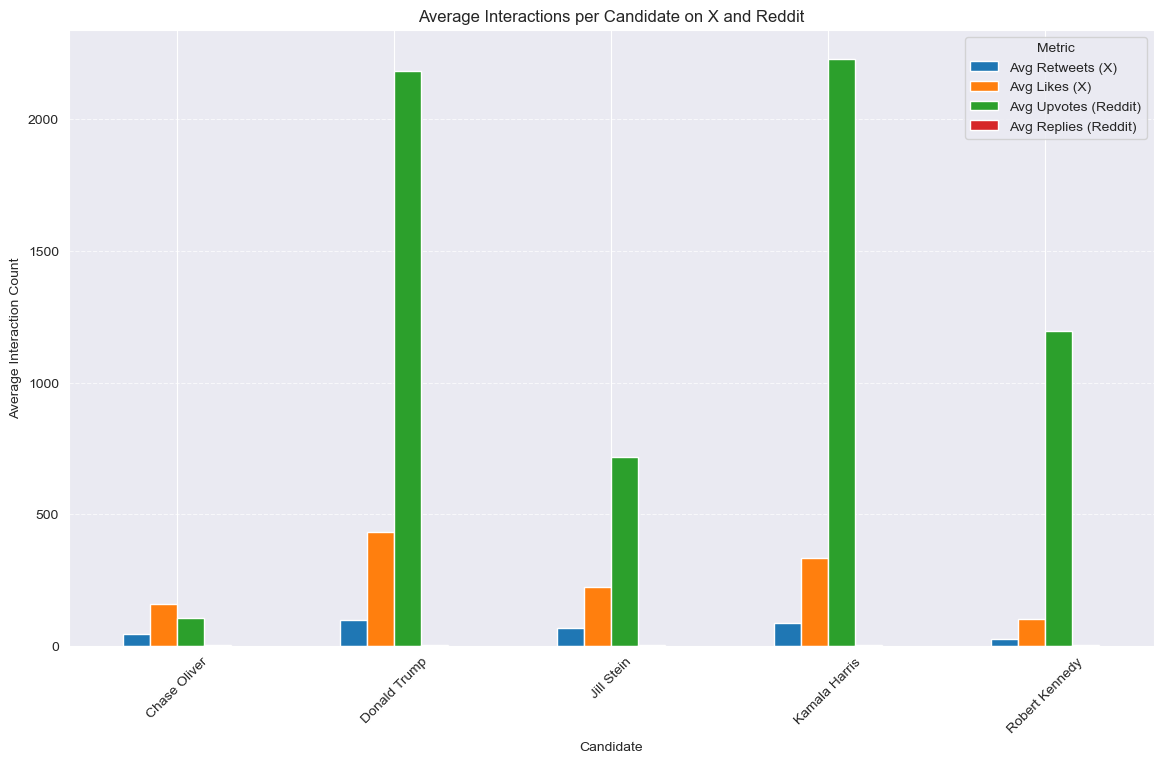

In [2]:
# Retweets and likes distribution for X data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='retweets', y='likes', data=data_x, hue='party', palette='tab10')
plt.title('Retweets vs Likes Colored by Party (X)')
plt.xlabel('Retweets')
plt.ylabel('Likes')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Upvotes and replies distribution for Reddit data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='upvotes', y='replies', data=data_r, hue='party', palette='tab10')
plt.title('Upvotes vs Replies Colored by Party (Reddit)')
plt.xlabel('Upvotes')
plt.ylabel('Replies')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Average interactions per candidate for X data
x_candidate_stats = data_x.groupby('candidate')[['retweets', 'likes']].mean()
x_candidate_stats.columns = ['Avg Retweets (X)', 'Avg Likes (X)']

# Average interactions per candidate for Reddit data
reddit_candidate_stats = data_r.groupby('candidate')[['upvotes', 'replies']].mean()
reddit_candidate_stats.columns = ['Avg Upvotes (Reddit)', 'Avg Replies (Reddit)']

# Combine stats for comparison
combined_stats = pd.concat([x_candidate_stats, reddit_candidate_stats], axis=1)

# Display combined stats
print("\nCombined average interaction stats per candidate:")
print(combined_stats)

# Visualize combined stats
combined_stats.plot(kind='bar', figsize=(14, 8))
plt.title('Average Interactions per Candidate on X and Reddit')
plt.xlabel('Candidate')
plt.ylabel('Average Interaction Count')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Social Network Analysis of X and Reddit Data

This section constructs directed graphs to represent interaction networks on X (Twitter) and Reddit. The aim is to visualize and analyze the structure and properties of these networks, focusing on retweets (X) and replies (Reddit).


X Network:
Number of nodes (X): 2937
Number of edges (X): 2500
Network density (X): 0.0002899212249241334

Reddit Network:
Number of nodes (Reddit): 1707
Number of edges (Reddit): 1285
Network density (Reddit): 0.0004412559552384465


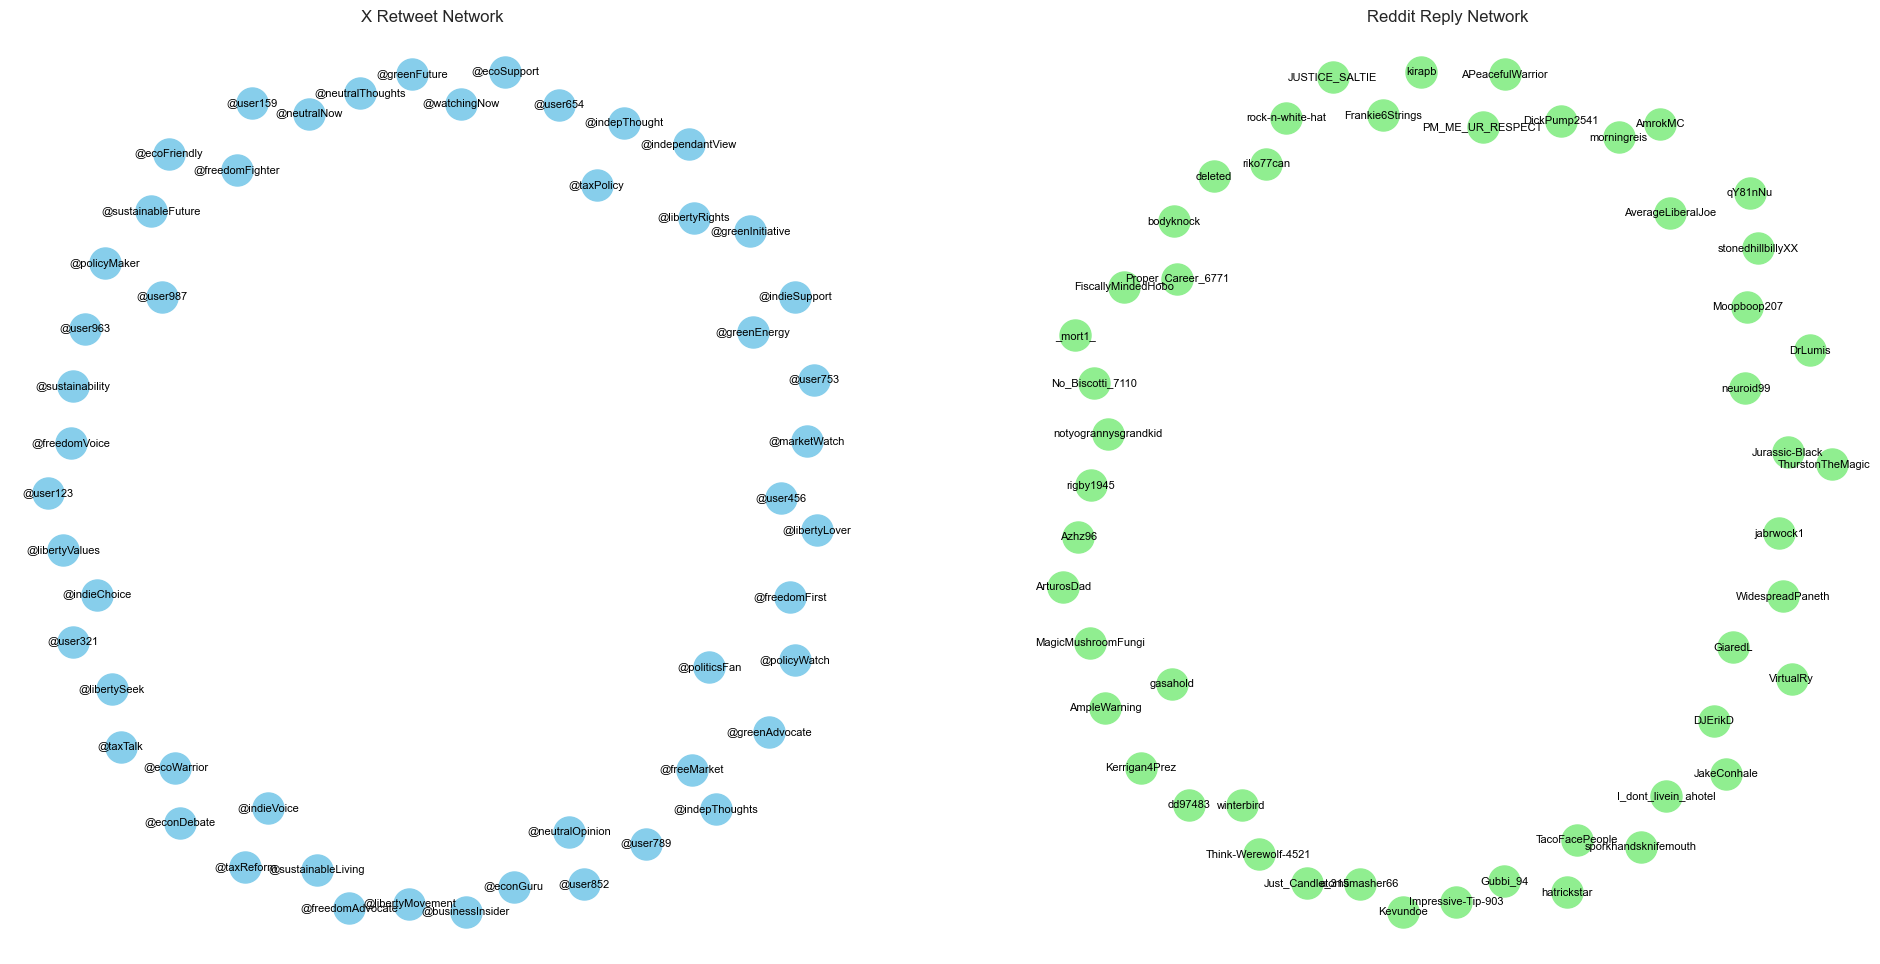

In [3]:
# Create directed graphs for Twitter and Reddit
G_x = nx.DiGraph()
G_r = nx.DiGraph()

# Add Twitter nodes and edges
users_x = data_x['user_handle'].unique()
G_x.add_nodes_from(users_x)

for _, row in data_x.iterrows():
    source_user = row['user_handle']
    retweet_count = row['retweets']
    for i in range(min(retweet_count, 5)):
        target_user = f"retweeter_{row['tweet_id']}_{i}"
        G_x.add_node(target_user)
        G_x.add_edge(source_user, target_user)

# Add Reddit nodes and edges
users_r = data_r['user_handle'].unique()
G_r.add_nodes_from(users_r)

for _, row in data_r.iterrows():
    source_user = row['user_handle']
    reply_count = row['replies']
    for i in range(min(reply_count, 5)):
        target_user = f"replier_{row['comment_id']}_{i}"
        G_r.add_node(target_user)
        G_r.add_edge(source_user, target_user)

# Analyze the networks
print("X Network:")
print("Number of nodes (X):", G_x.number_of_nodes())
print("Number of edges (X):", G_x.number_of_edges())
print("Network density (X):", nx.density(G_x))

print("\nReddit Network:")
print("Number of nodes (Reddit):", G_r.number_of_nodes())
print("Number of edges (Reddit):", G_r.number_of_edges())
print("Network density (Reddit):", nx.density(G_r))

plt.figure(figsize=(24, 12))

# Twitter network
plt.subplot(1, 2, 1)
small_subgraph_x = G_x.subgraph(list(G_x.nodes)[:50])  # Visualize only 50 nodes
pos_x = nx.spring_layout(small_subgraph_x)
nx.draw(
    small_subgraph_x, pos_x, with_labels=True, node_size=500,
    node_color="skyblue", edge_color="gray", font_size=8
)
plt.title("X Retweet Network")

# Reddit network
plt.subplot(1, 2, 2)
small_subgraph_r = G_r.subgraph(list(G_r.nodes)[:50])  # Visualize only 50 nodes
pos_r = nx.spring_layout(small_subgraph_r)
nx.draw(
    small_subgraph_r, pos_r, with_labels=True, node_size=500,
    node_color="lightgreen", edge_color="gray", font_size=8
)
plt.title("Reddit Reply Network")

plt.show()

# Sentiment Analysis on X and Reddit Data

This section processes text data from X and Reddit to prepare it for sentiment analysis. The workflow includes text cleaning, sentiment scoring with a pre-trained model, and nonlinear scaling of sentiment scores. The goal is to standardize and analyze user sentiment across both platforms.

In [4]:
# Function to clean text (generalized for both X and Reddit)
def clean_text(text, platform="general"):
    """
    Clean text for sentiment analysis:
    - Remove URLs, special characters, extra spaces.
    - Handle platform-specific markers like mentions or subreddit references.
    """
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    if platform == "reddit":
        text = re.sub(r"u/[A-Za-z0-9_]+", "", text)  # Remove Reddit user mentions
        text = re.sub(r"r/[A-Za-z0-9_]+", "", text)  # Remove subreddit references
    elif platform == "x":
        text = re.sub(r"@\w+", "", text)  # Remove Twitter mentions
        text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    return text

# Load pre-trained sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to compute sentiment score with nonlinear scaling
def compute_sentiment_score_nonlinear(text):
    """
    Compute sentiment score:
    - Use pre-trained model to classify text.
    - Apply nonlinear scaling to amplify sentiment differences.
    - Map scores to a 0-10 range.
    """
    try:
        result = sentiment_analyzer(text)
        label = result[0]['label']  # 'POSITIVE' or 'NEGATIVE'
        score = result[0]['score']  # Confidence score (0 to 1)
        score = score**2  # Nonlinear scaling
        # Map scores: Negative (0-5), Positive (5-10)
        if label == 'NEGATIVE':
            return score * 5
        elif label == 'POSITIVE':
            return 5 + (score * 5)
    except Exception as e:
        return None  # Return None for errors or empty input

# Process X Data
data_x['cleaned_tweet_text'] = data_x['tweet_text'].apply(lambda x: clean_text(x, platform="x"))
data_x['sentiment_score'] = data_x['cleaned_tweet_text'].apply(compute_sentiment_score_nonlinear)

# Process Reddit Data
data_r['cleaned_comment_text'] = data_r['comment_text'].apply(lambda x: clean_text(x, platform="reddit"))
data_r['sentiment_score'] = data_r['cleaned_comment_text'].apply(compute_sentiment_score_nonlinear)

# Display processed X data
print("Processed X Data:")
print(data_x[['tweet_text', 'cleaned_tweet_text', 'sentiment_score']].head())

# Display processed Reddit data
print("\nProcessed Reddit Data:")
print(data_r[['comment_text', 'cleaned_comment_text', 'sentiment_score']].head())

Processed X Data:
                                          tweet_text  \
0  Excited to see Kamala Harris leading the Democ...   
1  Donald Trump's policies are the best for our e...   
2  Jill Stein's environmental plans are exactly w...   
3  Robert Kennedy offers a fresh perspective outs...   
4  Chase Oliver's libertarian stance promotes tru...   

                                  cleaned_tweet_text  sentiment_score  
0  excited to see kamala harris leading the democ...         9.997552  
1  donald trumps policies are the best for our ec...         9.994654  
2  jill steins environmental plans are exactly wh...         9.992163  
3  robert kennedy offers a fresh perspective outs...         9.996318  
4  chase olivers libertarian stance promotes true...         9.960117  

Processed Reddit Data:
                                        comment_text  \
0  While I think the Libertarian party is full of...   
1         But his brain worm is still in the running   
2  True libertarian a

# LDA Topic Modeling and Visualization for X and Reddit Data

This section performs Latent Dirichlet Allocation (LDA) to identify topics within cleaned text data from X (formerly Twitter) and Reddit. The results are visualized using word clouds for intuitive interpretation, and a comparison between the two platforms is presented.


Performing LDA and generating word clouds for X data...

Top 10 words per topic for X:
Topic 1: latest, solar, tax, energy, sustainable, healthcare, trumps, steins, policies, jill
Topic 2: offers, education, bipartisan, new, jill, solutions, kennedy, robert, kamala, harris
Topic 3: economic, setting, new, foreign, climate, policy, initiatives, trumps, harriss, kamala
Topic 4: advocates, commitment, freedoms, liberty, kennedy, robert, olivers, voters, oliver, chase
Topic 5: stance, diverse, jill, stein, reforms, trade, independent, robert, kennedys, trumps


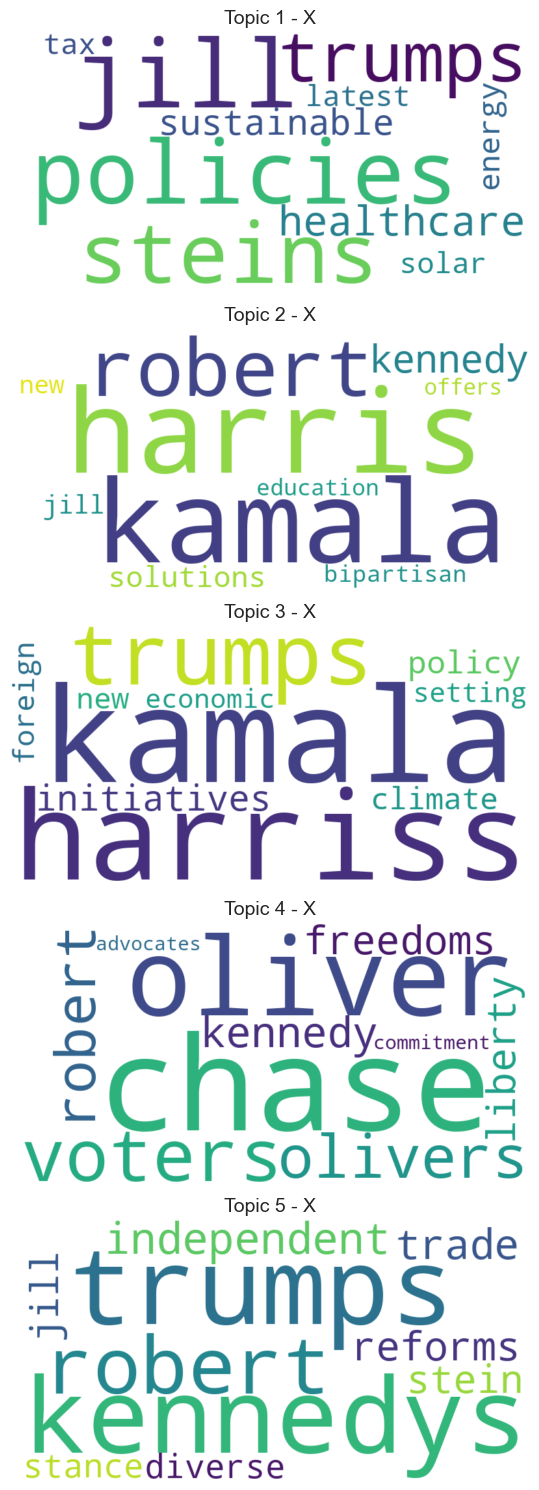


Performing LDA and generating word clouds for Reddit data...

Top 10 words per topic for Reddit:
Topic 1: green, change, court, state, people, supports, party, im, oliver, voting
Topic 2: voted, rfk, theyll, president, trump, just, theyre, going, people, think
Topic 3: years, didnt, make, actually, said, like, win, just, trump, vote
Topic 4: want, fuck, people, time, vote, im, dont, like, just, trump
Topic 5: like, thats, green, just, people, dont, russia, stein, deleted, party


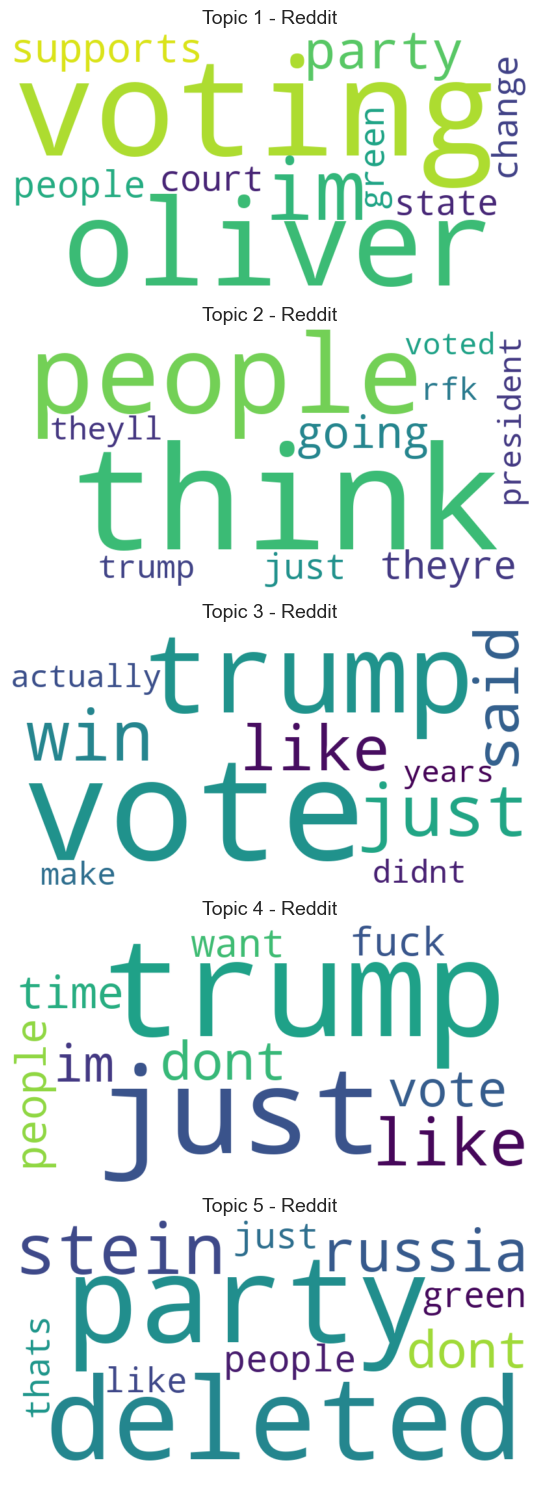


Topic Comparison Between X and Reddit:
                                            X Topics  \
0  latest; solar; tax; energy; sustainable; healt...   
1  offers; education; bipartisan; new; jill; solu...   
2  economic; setting; new; foreign; climate; poli...   
3  advocates; commitment; freedoms; liberty; kenn...   
4  stance; diverse; jill; stein; reforms; trade; ...   

                                       Reddit Topics  
0  green; change; court; state; people; supports;...  
1  voted; rfk; theyll; president; trump; just; th...  
2  years; didnt; make; actually; said; like; win;...  
3  want; fuck; people; time; vote; im; dont; like...  
4  like; thats; green; just; people; dont; russia...  


In [5]:
# Function to perform LDA topic modeling
def perform_lda_and_visualize(text_data, platform_name, n_topics=5, n_top_words=10):
    """
    Perform LDA topic modeling and visualize topics with word clouds.
    """
    # Vectorize the text data
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    text_matrix = vectorizer.fit_transform(text_data)
    
    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(text_matrix)
    
    # Display and visualize topics
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    print(f"\nTop {n_top_words} words per topic for {platform_name}:")
    
    # Prepare for word clouds
    plt.figure(figsize=(15, n_topics * 3))
    for idx, topic in enumerate(lda.components_):
        # Extract top words for each topic
        top_words = {feature_names[i]: topic[i] for i in topic.argsort()[-n_top_words:]}
        topics[f"Topic {idx + 1}"] = list(top_words.keys())
        print(f"Topic {idx + 1}: {', '.join(top_words.keys())}")
        
        # Generate and plot word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
        plt.subplot(n_topics, 1, idx + 1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Topic {idx + 1} - {platform_name}", fontsize=14)
    
    plt.tight_layout()
    plt.show()
    return topics

# Perform LDA and visualize for X data
print("Performing LDA and generating word clouds for X data...")
topics_x = perform_lda_and_visualize(data_x['cleaned_tweet_text'], platform_name="X", n_topics=5, n_top_words=10)

# Perform LDA and visualize for Reddit data
print("\nPerforming LDA and generating word clouds for Reddit data...")
topics_r = perform_lda_and_visualize(data_r['cleaned_comment_text'], platform_name="Reddit", n_topics=5, n_top_words=10)

# Combine topics into a comparison DataFrame
comparison_df = pd.DataFrame({
    "X Topics": ["; ".join(topics_x[f"Topic {i + 1}"]) for i in range(len(topics_x))],
    "Reddit Topics": ["; ".join(topics_r[f"Topic {i + 1}"]) for i in range(len(topics_r))]
})
print("\nTopic Comparison Between X and Reddit:")
print(comparison_df)

# Fake News Detection and Analysis on X and Reddit Data

This section detects fake news in textual data from X and Reddit using a pre-trained `RoBERTa` model. It further analyzes and visualizes the distribution of fake vs non-fake content and its impact on interaction metrics such as retweets, likes, upvotes, and replies.


Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fake news detection counts for X data:
fake_news_label
Fake    257
Real    243
Name: count, dtype: int64

Fake news detection counts for Reddit data:
fake_news_label
Real    329
Fake    171
Name: count, dtype: int64


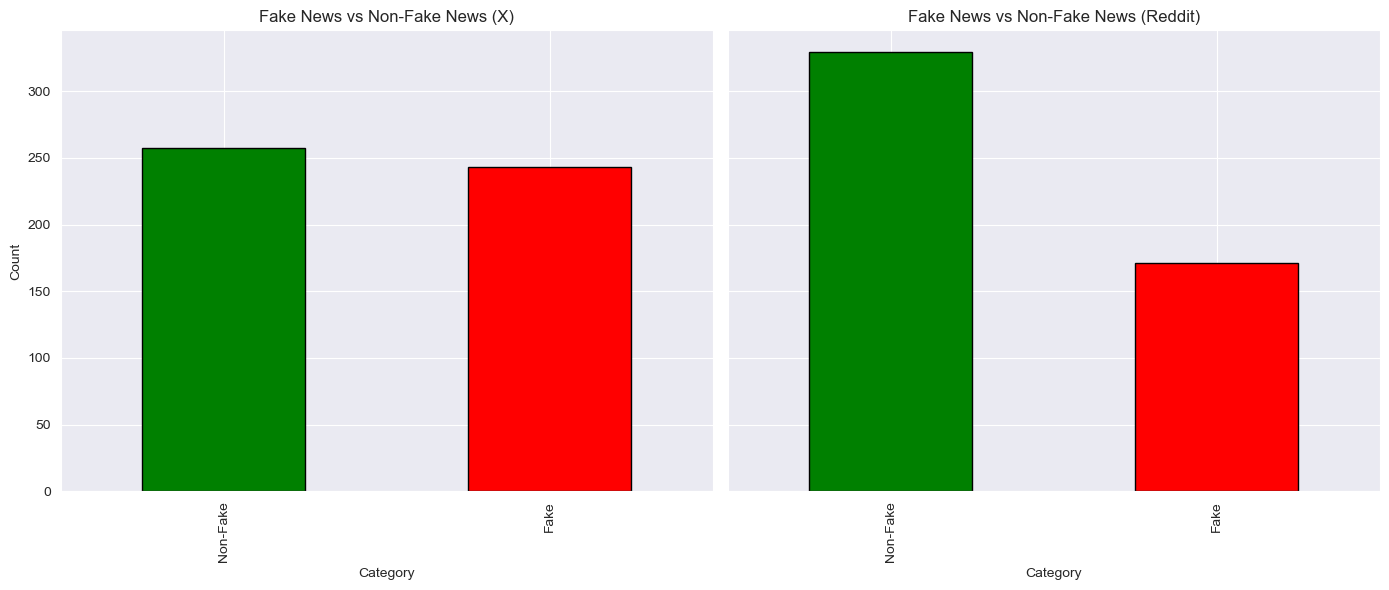


Average interaction metrics for fake vs non-fake tweets (X):
                  retweets       likes
fake_news_label                       
Fake             69.070039  260.077821
Real             59.123457  237.119342

Average interaction metrics for fake vs non-fake comments (Reddit):
                     upvotes   replies
fake_news_label                       
Fake             1128.064327  2.631579
Real             1368.680851  3.386018


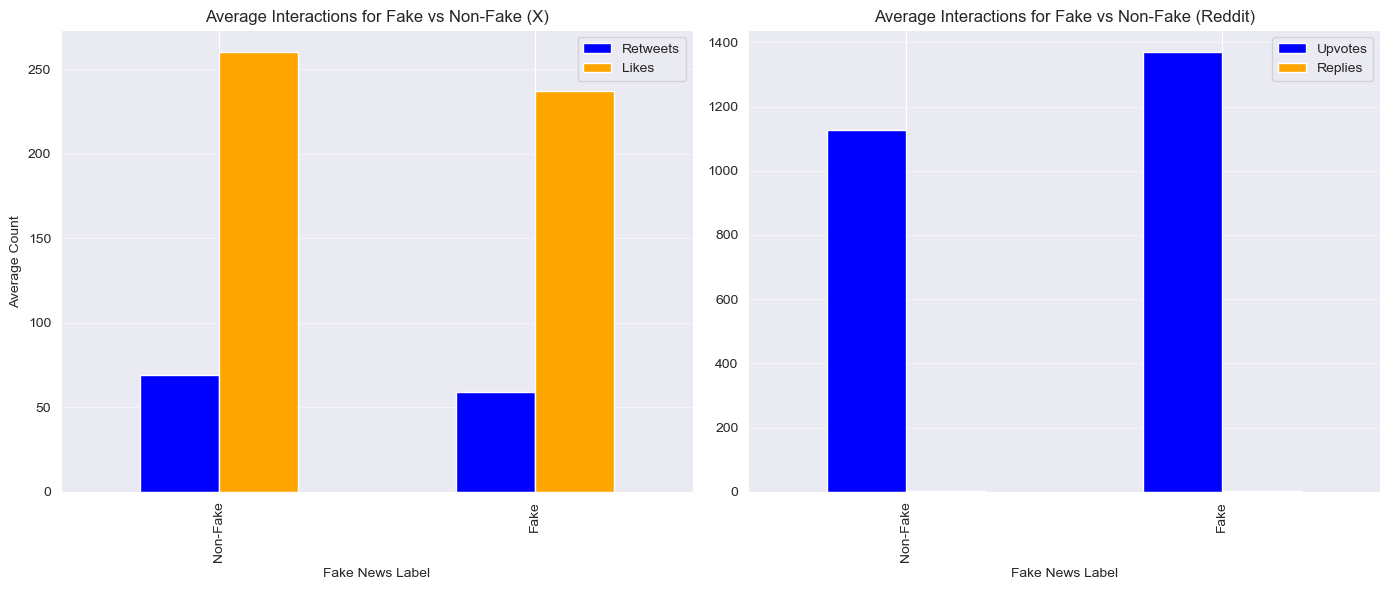

In [6]:
# Load a pretrained fake news detector
fake_news_detector = pipeline("text-classification", model="roberta-base-openai-detector")

# Function to classify text as misinformation or not
def detect_fake_news(text):
    """
    Detect if the text is fake or non-fake using a pre-trained model.
    """
    try:
        result = fake_news_detector(text)
        return result[0]['label']  # 'LABEL_0' (non-fake) or 'LABEL_1' (fake)
    except Exception as e:
        return None

# Apply fake news detection to X data
data_x['fake_news_label'] = data_x['cleaned_tweet_text'].apply(detect_fake_news)

# Apply fake news detection to Reddit data
data_r['fake_news_label'] = data_r['cleaned_comment_text'].apply(detect_fake_news)

# Count fake vs non-fake for X data
fake_news_count_x = data_x['fake_news_label'].value_counts()
print("Fake news detection counts for X data:")
print(fake_news_count_x)

# Count fake vs non-fake for Reddit data
fake_news_count_r = data_r['fake_news_label'].value_counts()
print("\nFake news detection counts for Reddit data:")
print(fake_news_count_r)

# Visualize fake news distribution for both platforms
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# X Data
fake_news_count_x.plot(kind='bar', color=['green', 'red'], edgecolor='black', ax=ax[0])
ax[0].set_title("Fake News vs Non-Fake News (X)")
ax[0].set_xlabel("Category")
ax[0].set_ylabel("Count")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Non-Fake', 'Fake'])

# Reddit Data
fake_news_count_r.plot(kind='bar', color=['green', 'red'], edgecolor='black', ax=ax[1])
ax[1].set_title("Fake News vs Non-Fake News (Reddit)")
ax[1].set_xlabel("Category")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Non-Fake', 'Fake'])

plt.tight_layout()
plt.show()

# Analyze interaction metrics for X data
interaction_metrics_x = data_x.groupby('fake_news_label')[['retweets', 'likes']].mean()
print("\nAverage interaction metrics for fake vs non-fake tweets (X):")
print(interaction_metrics_x)

# Analyze interaction metrics for Reddit data
interaction_metrics_r = data_r.groupby('fake_news_label')[['upvotes', 'replies']].mean()
print("\nAverage interaction metrics for fake vs non-fake comments (Reddit):")
print(interaction_metrics_r)

# Visualize interaction metrics comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# X Data
interaction_metrics_x.plot(kind='bar', color=['blue', 'orange'], ax=ax[0])
ax[0].set_title("Average Interactions for Fake vs Non-Fake (X)")
ax[0].set_xlabel("Fake News Label")
ax[0].set_ylabel("Average Count")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Non-Fake', 'Fake'])
ax[0].legend(["Retweets", "Likes"])
ax[0].grid(axis='y', alpha=0.5)

# Reddit Data
interaction_metrics_r.plot(kind='bar', color=['blue', 'orange'], ax=ax[1])
ax[1].set_title("Average Interactions for Fake vs Non-Fake (Reddit)")
ax[1].set_xlabel("Fake News Label")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Non-Fake', 'Fake'])
ax[1].legend(["Upvotes", "Replies"])
ax[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()



Fake News Stats (X Data):
                fake_tweets_count  total_tweets_count  fake_tweets_percentage
candidate                                                                    
Chase Oliver                   32                 100                    32.0
Donald Trump                   36                 100                    36.0
Jill Stein                     75                 100                    75.0
Kamala Harris                  75                 100                    75.0
Robert Kennedy                 39                 100                    39.0

Fake News Stats (Reddit Data):
                fake_comments_count  total_comments_count  \
candidate                                                   
Chase Oliver                     49                   100   
Donald Trump                     31                   100   
Jill Stein                       29                   100   
Kamala Harris                    35                   100   
Robert Kennedy               

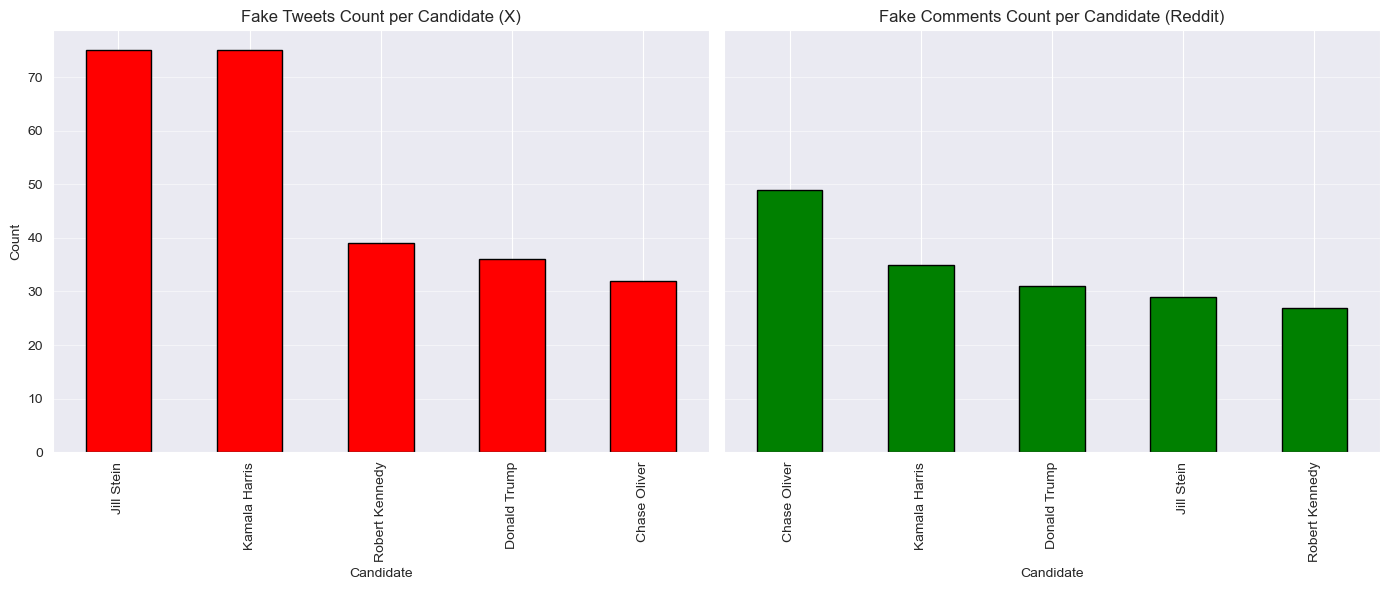

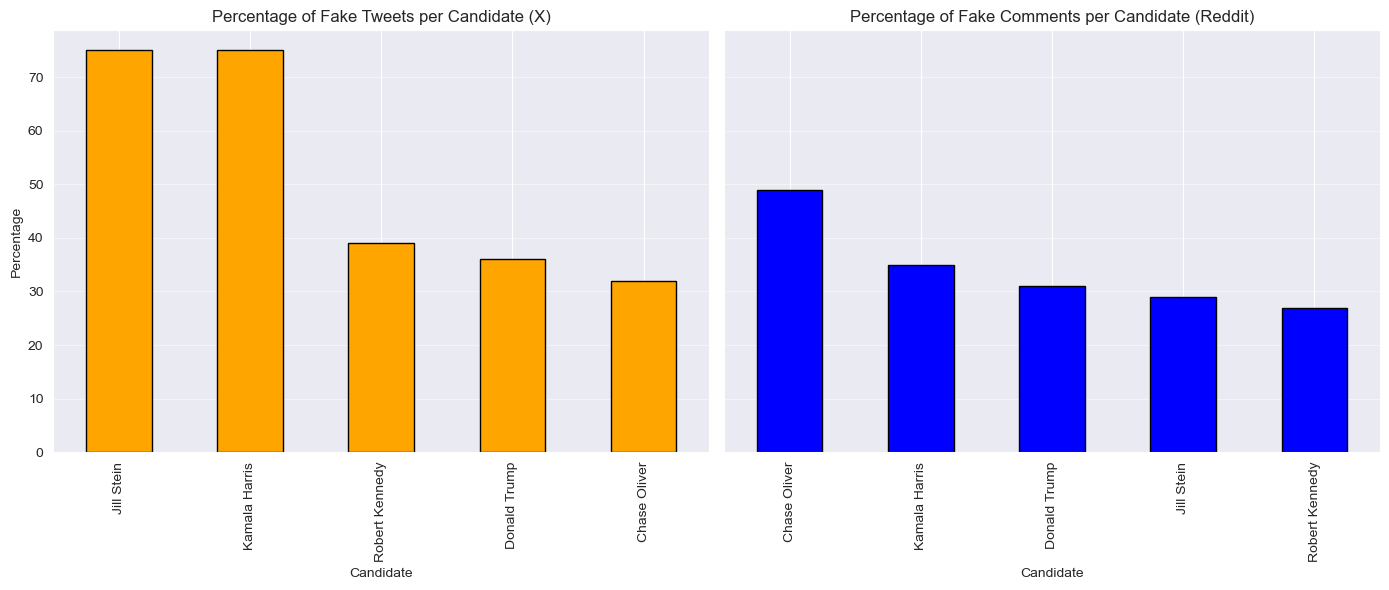

In [7]:
# Count fake news tweets per candidate (X data)
candidate_fake_tweets_x = data_x[data_x['fake_news_label'] == 'Fake'].groupby('candidate')['fake_news_label'].count()
candidate_total_tweets_x = data_x.groupby('candidate')['tweet_id'].count()

# Combine results for X data
fake_tweets_stats_x = pd.DataFrame({
    'fake_tweets_count': candidate_fake_tweets_x,
    'total_tweets_count': candidate_total_tweets_x
}).fillna(0)
fake_tweets_stats_x['fake_tweets_percentage'] = (fake_tweets_stats_x['fake_tweets_count'] / fake_tweets_stats_x['total_tweets_count']) * 100

# Count fake news comments per candidate (Reddit data)
candidate_fake_comments_r = data_r[data_r['fake_news_label'] == 'Fake'].groupby('candidate')['fake_news_label'].count()
candidate_total_comments_r = data_r.groupby('candidate')['comment_id'].count()

# Combine results for Reddit data
fake_comments_stats_r = pd.DataFrame({
    'fake_comments_count': candidate_fake_comments_r,
    'total_comments_count': candidate_total_comments_r
}).fillna(0)
fake_comments_stats_r['fake_comments_percentage'] = (fake_comments_stats_r['fake_comments_count'] / fake_comments_stats_r['total_comments_count']) * 100

# Display combined stats
print("\nFake News Stats (X Data):")
print(fake_tweets_stats_x)

print("\nFake News Stats (Reddit Data):")
print(fake_comments_stats_r)

# Visualize fake news count comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Fake tweets count (X data)
fake_tweets_stats_x['fake_tweets_count'].sort_values(ascending=False).plot(
    kind='bar', color='red', edgecolor='black', ax=ax[0]
)
ax[0].set_title("Fake Tweets Count per Candidate (X)")
ax[0].set_xlabel("Candidate")
ax[0].set_ylabel("Count")
ax[0].grid(axis='y', alpha=0.5)

# Fake comments count (Reddit data)
fake_comments_stats_r['fake_comments_count'].sort_values(ascending=False).plot(
    kind='bar', color='green', edgecolor='black', ax=ax[1]
)
ax[1].set_title("Fake Comments Count per Candidate (Reddit)")
ax[1].set_xlabel("Candidate")
ax[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

# Visualize fake news percentage comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Fake tweets percentage (X data)
fake_tweets_stats_x['fake_tweets_percentage'].sort_values(ascending=False).plot(
    kind='bar', color='orange', edgecolor='black', ax=ax[0]
)
ax[0].set_title("Percentage of Fake Tweets per Candidate (X)")
ax[0].set_xlabel("Candidate")
ax[0].set_ylabel("Percentage")
ax[0].grid(axis='y', alpha=0.5)

# Fake comments percentage (Reddit data)
fake_comments_stats_r['fake_comments_percentage'].sort_values(ascending=False).plot(
    kind='bar', color='blue', edgecolor='black', ax=ax[1]
)
ax[1].set_title("Percentage of Fake Comments per Candidate (Reddit)")
ax[1].set_xlabel("Candidate")
ax[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()


# Analysis of Sentiment, Correlation, and Regression Across X and Reddit Data

This section performs a detailed analysis of sentiment, user interactions, and text similarity between X and Reddit. It includes correlation matrices, scatterplots, similarity heatmaps, and regression analysis to uncover relationships between sentiment and interaction metrics.


Correlation matrix (X data):
                 sentiment_score  retweets     likes
sentiment_score         1.000000 -0.250255 -0.312665
retweets               -0.250255  1.000000  0.971536
likes                  -0.312665  0.971536  1.000000

Correlation matrix (Reddit data):
                 sentiment_score   upvotes   replies
sentiment_score         1.000000 -0.020404 -0.100316
upvotes                -0.020404  1.000000  0.487340
replies                -0.100316  0.487340  1.000000


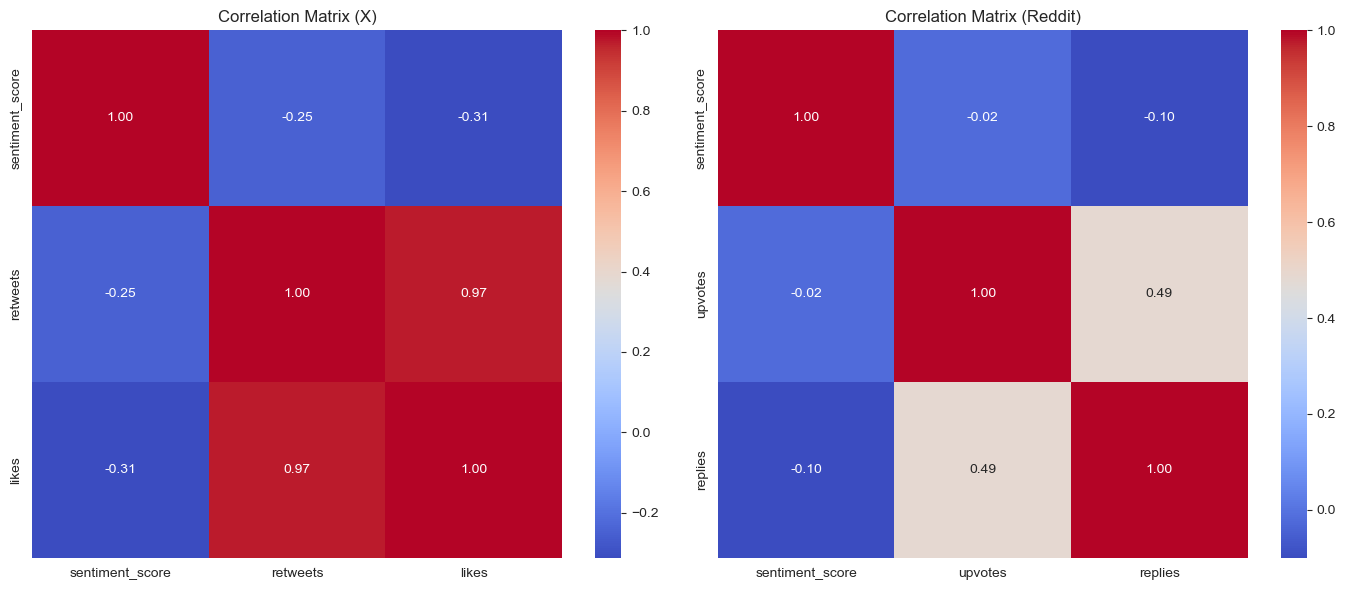

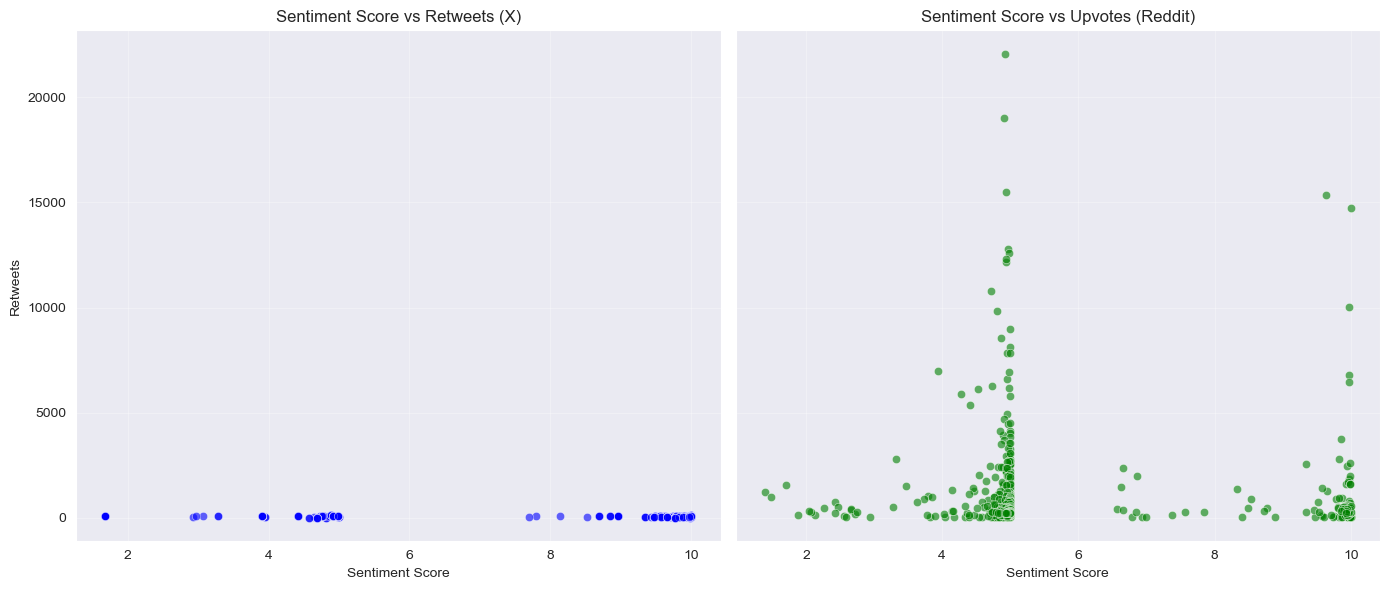

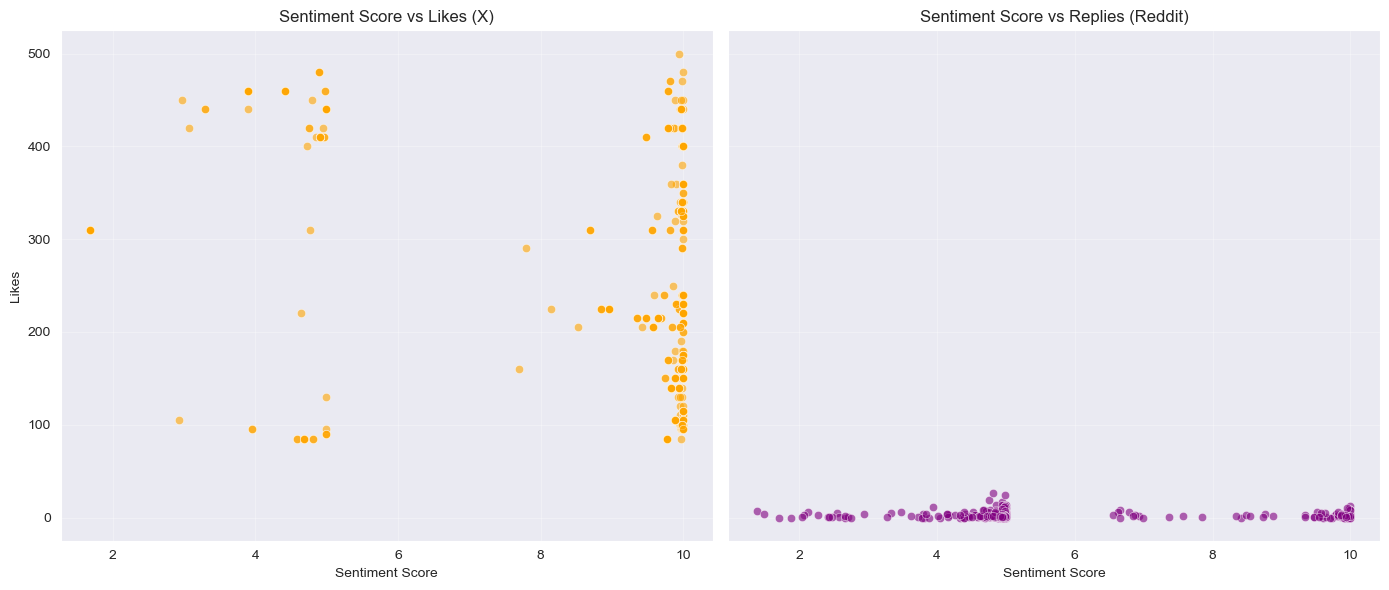

In [8]:
# Correlation analysis for X data
correlation_x = data_x[['sentiment_score', 'retweets', 'likes']].corr()
print("Correlation matrix (X data):")
print(correlation_x)

# Correlation analysis for Reddit data
correlation_r = data_r[['sentiment_score', 'upvotes', 'replies']].corr()
print("\nCorrelation matrix (Reddit data):")
print(correlation_r)

# Visualize correlation matrices
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# X Data
sns.heatmap(correlation_x, annot=True, cmap="coolwarm", fmt=".2f", ax=ax[0])
ax[0].set_title("Correlation Matrix (X)")

# Reddit Data
sns.heatmap(correlation_r, annot=True, cmap="coolwarm", fmt=".2f", ax=ax[1])
ax[1].set_title("Correlation Matrix (Reddit)")

plt.tight_layout()
plt.show()

# Scatterplot: Sentiment vs Retweets (X) and Sentiment vs Upvotes (Reddit)
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# X Data
sns.scatterplot(x='sentiment_score', y='retweets', data=data_x, color='blue', alpha=0.6, ax=ax[0])
ax[0].set_title("Sentiment Score vs Retweets (X)")
ax[0].set_xlabel("Sentiment Score")
ax[0].set_ylabel("Retweets")
ax[0].grid(alpha=0.3)

# Reddit Data
sns.scatterplot(x='sentiment_score', y='upvotes', data=data_r, color='green', alpha=0.6, ax=ax[1])
ax[1].set_title("Sentiment Score vs Upvotes (Reddit)")
ax[1].set_xlabel("Sentiment Score")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Scatterplot: Sentiment vs Likes (X) and Sentiment vs Replies (Reddit)
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# X Data
sns.scatterplot(x='sentiment_score', y='likes', data=data_x, color='orange', alpha=0.6, ax=ax[0])
ax[0].set_title("Sentiment Score vs Likes (X)")
ax[0].set_xlabel("Sentiment Score")
ax[0].set_ylabel("Likes")
ax[0].grid(alpha=0.3)

# Reddit Data
sns.scatterplot(x='sentiment_score', y='replies', data=data_r, color='purple', alpha=0.6, ax=ax[1])
ax[1].set_title("Sentiment Score vs Replies (Reddit)")
ax[1].set_xlabel("Sentiment Score")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

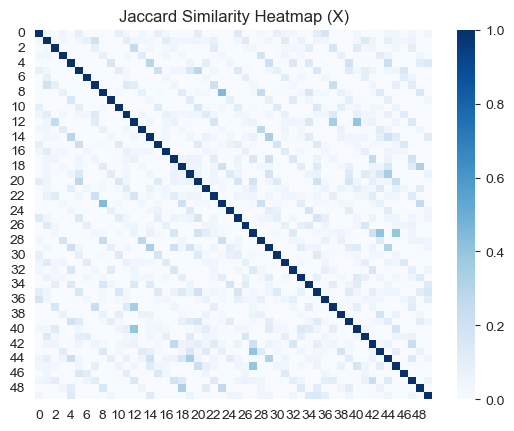

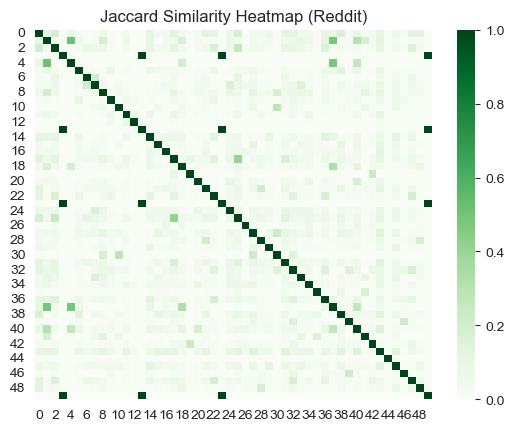

In [9]:
# Vectorize text data
tfidf = TfidfVectorizer()
tfidf_matrix_x = tfidf.fit_transform(data_x['cleaned_tweet_text'])
tfidf_matrix_r = tfidf.fit_transform(data_r['cleaned_comment_text'])

# Calculate Jaccard similarity
similarity_x = (tfidf_matrix_x * tfidf_matrix_x.T).toarray()
similarity_r = (tfidf_matrix_r * tfidf_matrix_r.T).toarray()

# Visualize similarity heatmaps
sns.heatmap(similarity_x[:50, :50], cmap="Blues")
plt.title("Jaccard Similarity Heatmap (X)")
plt.show()

sns.heatmap(similarity_r[:50, :50], cmap="Greens")
plt.title("Jaccard Similarity Heatmap (Reddit)")
plt.show()



Regression Results (X):
R-squared: 0.15
Coefficients:
    Feature  Coefficient
0  retweets     0.071297
1     likes    -0.021298

Regression Results (Reddit):
R-squared: 0.01
Coefficients:
   Feature  Coefficient
0  upvotes     0.000031
1  replies    -0.079172

Comparison of Coefficients:
    Feature  X Coefficient  Reddit Coefficient
0  retweets       0.071297            0.000000
1     likes      -0.021298            0.000000
2   upvotes       0.000000            0.000031
3   replies       0.000000           -0.079172


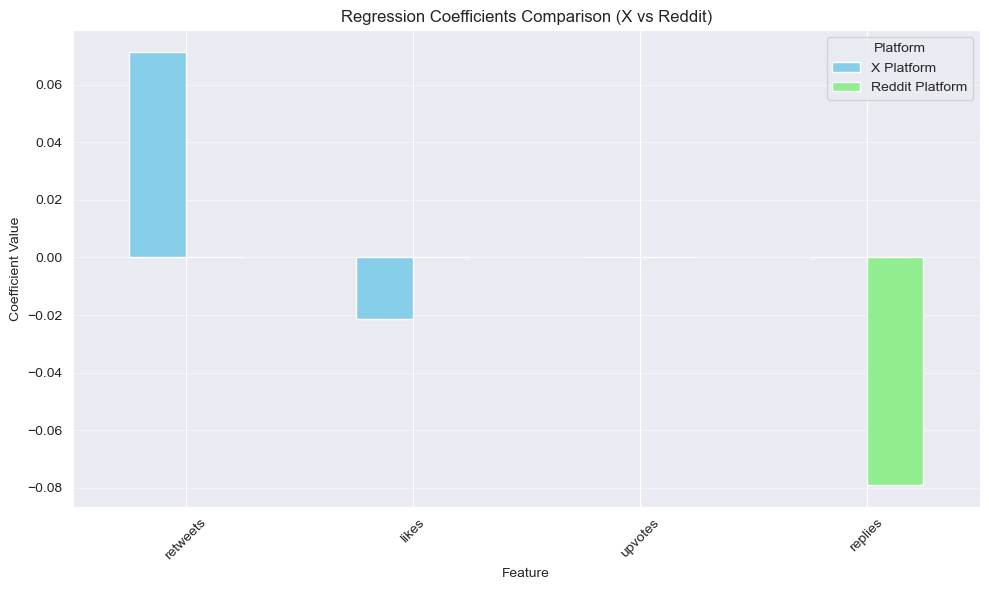

In [10]:
# Function to prepare data and perform regression analysis
def perform_regression(data, features, target, platform_name):
    """
    Perform regression analysis and return model details.
    """
    X = data[features]
    y = data[target]
    
    # Fit regression model
    model = LinearRegression().fit(X, y)
    
    # Predict and calculate R-squared
    y_pred = model.predict(X)
    r_squared = r2_score(y, y_pred)
    
    # Create a DataFrame for coefficients
    coef_df = pd.DataFrame({
        "Feature": features,
        "Coefficient": model.coef_
    })
    
    print(f"\nRegression Results ({platform_name}):")
    print(f"R-squared: {r_squared:.2f}")
    print("Coefficients:")
    print(coef_df)
    
    return model, r_squared, coef_df

# Define features and target for X and Reddit data
features_x = ['retweets', 'likes']
target_x = 'sentiment_score'
features_r = ['upvotes', 'replies']
target_r = 'sentiment_score'

# Perform regression for X data
model_x, r2_x, coef_x = perform_regression(data_x, features_x, target_x, platform_name="X")

# Perform regression for Reddit data
model_r, r2_r, coef_r = perform_regression(data_r, features_r, target_r, platform_name="Reddit")

# Combine coefficients for comparison
comparison_df = pd.DataFrame({
    "Feature": features_x + features_r,
    "X Coefficient": list(coef_x['Coefficient']) + [None, None],
    "Reddit Coefficient": [None, None] + list(coef_r['Coefficient'])
}).fillna(0)

# Display comparison table
print("\nComparison of Coefficients:")
print(comparison_df)

# Visualize coefficients comparison
comparison_df.set_index("Feature").plot(kind="bar", figsize=(10, 6), color=["skyblue", "lightgreen"])
plt.title("Regression Coefficients Comparison (X vs Reddit)")
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.legend(["X Platform", "Reddit Platform"], title="Platform")
plt.grid(axis="y", alpha=0.5)
plt.tight_layout()
plt.show()

# Weighted Sentiment Score Analysis for X and Reddit

This section calculates weighted sentiment scores for each platform (X and Reddit) by incorporating interaction metrics (retweets, likes, upvotes, and replies) into sentiment scores. The weighted scores provide a more nuanced view of public sentiment by factoring in user engagement levels.



Comparison of Weighted Average Sentiment Scores:
                X Platform  Reddit Platform
candidate                                  
Kamala Harris   102.811073        56.004847
Jill Stein      102.654241        43.476699
Chase Oliver     97.895153        35.828657
Donald Trump     86.087191        54.740298
Robert Kennedy   80.771176        46.904050


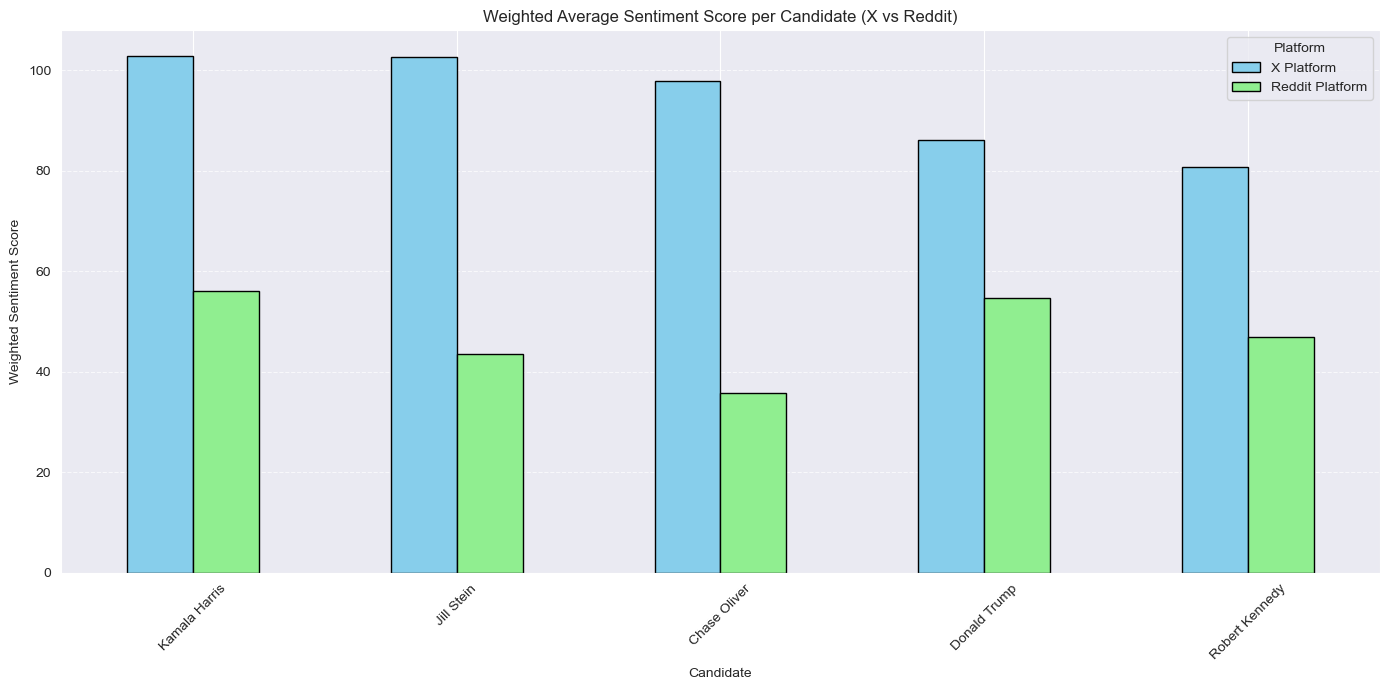

In [11]:
# Function to calculate weighted sentiment score for X data
def calculate_weighted_score_x(row):
    # Add 1 to avoid log(0)
    retweets_weight = np.log1p(row['retweets'])  # log(1 + retweets)
    likes_weight = np.log1p(row['likes'])       # log(1 + likes)
    weighted_score = row['sentiment_score'] * (1 + retweets_weight + likes_weight)
    return weighted_score

# Function to calculate weighted sentiment score for Reddit data
def calculate_weighted_score_reddit(row):
    # Add 1 to avoid log(0)
    upvotes_weight = np.log1p(row['upvotes'])  # log(1 + upvotes)
    replies_weight = np.log1p(row['replies'])  # log(1 + replies)
    weighted_score = row['sentiment_score'] * (1 + upvotes_weight + replies_weight)
    return weighted_score

# Apply the weighted score calculation to X data
data_x['weighted_sentiment_score'] = data_x.apply(calculate_weighted_score_x, axis=1)

# Apply the weighted score calculation to Reddit data
data_r['weighted_sentiment_score'] = data_r.apply(calculate_weighted_score_reddit, axis=1)

# Group by candidate and calculate the weighted average sentiment score for X data
candidate_scores_x = data_x.groupby('candidate')['weighted_sentiment_score'].mean()

# Group by candidate and calculate the weighted average sentiment score for Reddit data
candidate_scores_r = data_r.groupby('candidate')['weighted_sentiment_score'].mean()

# Combine results into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'X Platform': candidate_scores_x,
    'Reddit Platform': candidate_scores_r
}).sort_values(by='X Platform', ascending=False)

# Display the comparison table
print("\nComparison of Weighted Average Sentiment Scores:")
print(comparison_df)

# Visualize the comparison
comparison_df.plot(kind='bar', figsize=(14, 7), color=['skyblue', 'lightgreen'], edgecolor='black')
plt.title('Weighted Average Sentiment Score per Candidate (X vs Reddit)')
plt.xlabel('Candidate')
plt.ylabel('Weighted Sentiment Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Platform")
plt.tight_layout()
plt.show()